# Stock NeurIPS2018 Part 2. Train
This series is a reproduction of *the process in the paper Practical Deep Reinforcement Learning Approach for Stock Trading*. 

This is the second part of the NeurIPS2018 series, introducing how to use FinRL to make data into the gym form environment, and train DRL agents on it.

Other demos can be found at the repo of [FinRL-Tutorials]((https://github.com/AI4Finance-Foundation/FinRL-Tutorials)).

# Part 1. Install Packages

In [5]:
import gym
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

check_and_make_directories([TRAINED_MODEL_DIR])

# Part 2. Build A Market Environment in OpenAI Gym-style

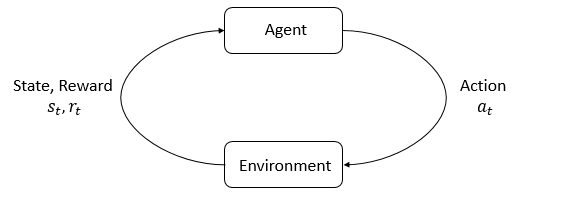

The core element in reinforcement learning are **agent** and **environment**. You can understand RL as the following process: 

The agent is active in a world, which is the environment. It observe its current condition as a **state**, and is allowed to do certain **actions**. After the agent execute an action, it will arrive at a new state. At the same time, the environment will have feedback to the agent called **reward**, a numerical signal that tells how good or bad the new state is. As the figure above, agent and environment will keep doing this interaction.

The goal of agent is to get as much cumulative reward as possible. Reinforcement learning is the method that agent learns to improve its behavior and achieve that goal.

To achieve this in Python, we follow the OpenAI gym style to build the stock data into environment.

state-action-reward are specified as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes the price data and technical indicators based on the past data. It will learn by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 constituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.

## Read data

We first read the .csv file of our training data into dataframe.

In [6]:
train = pd.read_csv('train_data_dow30_1989-01-01_2022-07-01.csv')
train = train.set_index(train.columns[0])
train.index.names = ['']
train

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix
,,,,,,,,,,,,,,,,,
0,1990-01-02,AAPL,0.262129,0.332589,0.334821,0.314732,183198400.0,1.0,-0.020410,0.407460,0.269995,37.182693,-57.773632,14.795458,0.358333,0.385603,17.24
0,1990-01-02,AMGN,0.754523,1.072917,1.072917,1.026042,19267200.0,1.0,-0.037307,1.269225,0.980255,44.088693,-108.941827,10.538710,1.152865,1.136372,17.24
0,1990-01-02,AXP,4.953164,8.979757,9.011943,8.915386,4301237.0,1.0,-0.113536,9.354541,7.880800,50.163415,44.429024,19.240226,8.751240,9.057539,17.24
0,1990-01-02,BA,11.043628,20.500000,20.500000,19.791668,2042400.0,1.0,-0.012113,20.580973,18.739861,53.656871,109.434371,42.703571,19.641667,19.314583,17.24
0,1990-01-02,CAT,3.208576,7.359375,7.359375,7.234375,2910400.0,1.0,-0.045713,7.750962,6.961538,47.910104,-16.224189,0.407785,7.323958,7.242448,17.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8187,2022-06-30,TRV,161.338013,169.130005,169.500000,164.610001,1336100.0,3.0,-2.374215,180.224943,156.931054,44.639520,-44.912598,8.641378,170.339999,173.666833,29.42
8187,2022-06-30,UNH,497.025818,513.630005,516.320007,513.549988,3568900.0,3.0,3.243815,522.217561,447.697438,54.941784,134.358930,26.659363,486.779667,500.980667,29.42
8187,2022-06-30,VZ,43.047783,50.750000,51.220001,50.669998,18880500.0,3.0,0.170573,52.597046,48.530953,50.161884,21.317367,13.348827,50.415666,50.484500,29.42


## Construct the environment

Calculate and specify the parameters we need for constructing the environment.

In [7]:
stock_dimension = len(train.tic.unique())
stock_dimension

25

In [8]:
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
state_space

251

In [9]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
}

e_train_gym = StockTradingEnv(df = train,**env_kwargs)

KeyboardInterrupt: 

## Environment for training

In [6]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Part 3: Train DRL Agents
* Here, the DRL algorithms are from **[Stable Baselines 3](https://stable-baselines3.readthedocs.io/en/master/)**. It's a library that implemented popular DRL algorithms using pytorch, succeeding to its old version: Stable Baselines.
* Users are also encouraged to try **[ElegantRL](https://github.com/AI4Finance-Foundation/ElegantRL)** and **[Ray RLlib](https://github.com/ray-project/ray)**.

In [25]:
agent = DRLAgent(env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True


## Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)

### Agent 1: A2C

In [8]:
agent = DRLAgent(env_train)
model_a2c = agent.get_model('a2c')

if if_using_a2c:
    tmp_path = RESULTS_DIR + '/a2c'
    new_logger_a2c = configure(tmp_path, ["stdout","csv", "tensorboard"])
    model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [9]:
trained_a2c = agent.train_model(model=model_a2c, tb_log_name='a2c', total_timesteps=50000) if if_using_a2c else None

/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


---------------------------------------
| time/                 |             |
|    fps                | 86          |
|    iterations         | 100         |
|    time_elapsed       | 5           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -35.8       |
|    explained_variance | -0.111      |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | 54.2        |
|    reward             | -0.03271399 |
|    std                | 1.02        |
|    value_loss         | 2.84        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 87        |
|    iterations         | 200       |
|    time_elapsed       | 11        |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -35.9     |
|    explained_variance | 0         |
|    learning_rate

/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


-------------------------------------
| time/                 |           |
|    fps                | 89        |
|    iterations         | 1700      |
|    time_elapsed       | 95        |
|    total_timesteps    | 8500      |
| train/                |           |
|    entropy_loss       | -36       |
|    explained_variance | 0.279     |
|    learning_rate      | 0.0007    |
|    n_updates          | 1699      |
|    policy_loss        | -53       |
|    reward             | 1.7516812 |
|    std                | 1.02      |
|    value_loss         | 2.57      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 89         |
|    iterations         | 1800       |
|    time_elapsed       | 101        |
|    total_timesteps    | 9000       |
| train/                |            |
|    entropy_loss       | -36.1      |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.0007     |
| 

/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


--------------------------------------
| time/                 |            |
|    fps                | 89         |
|    iterations         | 3300       |
|    time_elapsed       | 184        |
|    total_timesteps    | 16500      |
| train/                |            |
|    entropy_loss       | -36.2      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 3299       |
|    policy_loss        | -33        |
|    reward             | 0.96497303 |
|    std                | 1.03       |
|    value_loss         | 1.07       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 89         |
|    iterations         | 3400       |
|    time_elapsed       | 190        |
|    total_timesteps    | 17000      |
| train/                |            |
|    entropy_loss       | -36.3      |
|    explained_variance | 0          |
|    learning_rate      |

/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


---------------------------------------
| time/                 |             |
|    fps                | 89          |
|    iterations         | 5000        |
|    time_elapsed       | 278         |
|    total_timesteps    | 25000       |
| train/                |             |
|    entropy_loss       | -36.1       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 4999        |
|    policy_loss        | -106        |
|    reward             | -0.52426416 |
|    std                | 1.03        |
|    value_loss         | 9.97        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 89         |
|    iterations         | 5100       |
|    time_elapsed       | 284        |
|    total_timesteps    | 25500      |
| train/                |            |
|    entropy_loss       | -36.2      |
|    explained_variance | 1.19e-07   |
|    lear

/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


---------------------------------------
| time/                 |             |
|    fps                | 89          |
|    iterations         | 6600        |
|    time_elapsed       | 367         |
|    total_timesteps    | 33000       |
| train/                |             |
|    entropy_loss       | -36.2       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 6599        |
|    policy_loss        | -55.7       |
|    reward             | -0.42990914 |
|    std                | 1.03        |
|    value_loss         | 3.03        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 89        |
|    iterations         | 6700      |
|    time_elapsed       | 373       |
|    total_timesteps    | 33500     |
| train/                |           |
|    entropy_loss       | -36.2     |
|    explained_variance | 0         |
|    learning_rate

/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


--------------------------------------
| time/                 |            |
|    fps                | 90         |
|    iterations         | 8200       |
|    time_elapsed       | 455        |
|    total_timesteps    | 41000      |
| train/                |            |
|    entropy_loss       | -36.3      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 8199       |
|    policy_loss        | 8.9        |
|    reward             | 0.17636506 |
|    std                | 1.04       |
|    value_loss         | 0.139      |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 90         |
|    iterations         | 8300       |
|    time_elapsed       | 460        |
|    total_timesteps    | 41500      |
| train/                |            |
|    entropy_loss       | -36.3      |
|    explained_variance | 0          |
|    learning_rate      |

/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


--------------------------------------
| time/                 |            |
|    fps                | 90         |
|    iterations         | 9900       |
|    time_elapsed       | 548        |
|    total_timesteps    | 49500      |
| train/                |            |
|    entropy_loss       | -36.5      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 9899       |
|    policy_loss        | -1.33      |
|    reward             | 0.42677584 |
|    std                | 1.05       |
|    value_loss         | 0.327      |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 90        |
|    iterations         | 10000     |
|    time_elapsed       | 553       |
|    total_timesteps    | 50000     |
| train/                |           |
|    entropy_loss       | -36.5     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007  

In [10]:
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

### Agent 2: DDPG

In [11]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model('ddpg')

if if_using_ddpg:
    tmp_path = RESULTS_DIR + '/ddpg'
    new_logger_ddpg = configure(tmp_path, ["stdout","csv","tensorboard"])
    model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [12]:
trained_ddpg = agent.train_model(model=model_ddpg,
                                 tb_log_name='ddpg',
                                 total_timesteps=50000) if if_using_ddpg else None

/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (
/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


day: 8187, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 15028863.25
total_reward: 14028863.25
total_cost: 999.00
total_trades: 122805
Sharpe: 0.580


/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (
/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 60         |
|    time_elapsed    | 544        |
|    total_timesteps | 32752      |
| train/             |            |
|    actor_loss      | 5.18       |
|    critic_loss     | 30.8       |
|    learning_rate   | 0.001      |
|    n_updates       | 32651      |
|    reward          | -14.222589 |
-----------------------------------


/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (
/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (
/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


In [13]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

### Agent 3: PPO

In [14]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}

model_ppo = agent.get_model('ppo', model_kwargs=PPO_PARAMS)

if if_using_ppo:
    tmp_path = RESULTS_DIR + '/ppo'
    new_logger_ppo = configure(tmp_path, ["stdout","csv","tensorboard"])
    model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [19]:
trained_ppo = agent.train_model(model=model_ppo,
                                tb_log_name='ppo',
                                total_timesteps=50000) if if_using_ppo else None

/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


-----------------------------------------
| time/                   |             |
|    fps                  | 91          |
|    iterations           | 1           |
|    time_elapsed         | 22          |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.017176835 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -38         |
|    explained_variance   | 0.00726     |
|    learning_rate        | 0.00025     |
|    loss                 | 285         |
|    n_updates            | 810         |
|    policy_gradient_loss | -0.00176    |
|    reward               | -1.1960642  |
|    std                  | 1.11        |
|    value_loss           | 601         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 89          |
|    iterations           | 2     

/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


-----------------------------------------
| time/                   |             |
|    fps                  | 90          |
|    iterations           | 5           |
|    time_elapsed         | 113         |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.016996324 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -38.1       |
|    explained_variance   | 0.00229     |
|    learning_rate        | 0.00025     |
|    loss                 | 602         |
|    n_updates            | 850         |
|    policy_gradient_loss | -0.00375    |
|    reward               | -1.3652476  |
|    std                  | 1.11        |
|    value_loss           | 1.54e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 90          |
|    iterations           | 6     

/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


-----------------------------------------
| time/                   |             |
|    fps                  | 90          |
|    iterations           | 9           |
|    time_elapsed         | 203         |
|    total_timesteps      | 18432       |
| train/                  |             |
|    approx_kl            | 0.015288312 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -38.2       |
|    explained_variance   | 0.00495     |
|    learning_rate        | 0.00025     |
|    loss                 | 1.14e+03    |
|    n_updates            | 890         |
|    policy_gradient_loss | -0.00941    |
|    reward               | 1.4834479   |
|    std                  | 1.11        |
|    value_loss           | 1.63e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 90          |
|    iterations           | 10    

/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


-----------------------------------------
| time/                   |             |
|    fps                  | 91          |
|    iterations           | 13          |
|    time_elapsed         | 292         |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.014818619 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -38.3       |
|    explained_variance   | 0.00326     |
|    learning_rate        | 0.00025     |
|    loss                 | 1.34e+03    |
|    n_updates            | 930         |
|    policy_gradient_loss | -0.00499    |
|    reward               | 1.3736296   |
|    std                  | 1.12        |
|    value_loss           | 2.49e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 91          |
|    iterations           | 14    

/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


-----------------------------------------
| time/                   |             |
|    fps                  | 91          |
|    iterations           | 17          |
|    time_elapsed         | 381         |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.011697961 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -38.3       |
|    explained_variance   | 0.00515     |
|    learning_rate        | 0.00025     |
|    loss                 | 1.43e+03    |
|    n_updates            | 970         |
|    policy_gradient_loss | -0.00541    |
|    reward               | 1.6258563   |
|    std                  | 1.12        |
|    value_loss           | 3.09e+03    |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 91         |
|    iterations           | 18       

/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


-----------------------------------------
| time/                   |             |
|    fps                  | 91          |
|    iterations           | 21          |
|    time_elapsed         | 472         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.015336868 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -38.5       |
|    explained_variance   | 0.00225     |
|    learning_rate        | 0.00025     |
|    loss                 | 1.53e+03    |
|    n_updates            | 1010        |
|    policy_gradient_loss | -0.00548    |
|    reward               | 1.9652637   |
|    std                  | 1.13        |
|    value_loss           | 4.54e+03    |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 91         |
|    iterations           | 22       

/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


-----------------------------------------
| time/                   |             |
|    fps                  | 90          |
|    iterations           | 24          |
|    time_elapsed         | 540         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.021443706 |
|    clip_fraction        | 0.245       |
|    clip_range           | 0.2         |
|    entropy_loss         | -38.6       |
|    explained_variance   | -0.00324    |
|    learning_rate        | 0.00025     |
|    loss                 | 99.2        |
|    n_updates            | 1040        |
|    policy_gradient_loss | -0.00438    |
|    reward               | 0.08139352  |
|    std                  | 1.14        |
|    value_loss           | 242         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 90          |
|    iterations           | 25    

In [21]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

### Agent 4: TD3

In [22]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


In [23]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (
/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (
/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (
/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/l

day: 8187, episode: 50
begin_total_asset: 1000000.00
end_total_asset: 16626448.77
total_reward: 15626448.77
total_cost: 999.00
total_trades: 114618
Sharpe: 0.573
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 62         |
|    time_elapsed    | 525        |
|    total_timesteps | 32752      |
| train/             |            |
|    actor_loss      | -11.7      |
|    critic_loss     | 65.3       |
|    learning_rate   | 0.001      |
|    n_updates       | 32651      |
|    reward          | -15.933864 |
-----------------------------------


/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (
/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (
/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


In [24]:
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

### Agent 5: SAC

In [26]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [27]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=70000) if if_using_sac else None

/Users/zhengshuang/Documents/ProgramingGuide/SourceCode/GithubRepo/everyfine/FinRLLearn/FinRLExamples/.venv/lib/python3.10/site-packages/finrl/meta/env_stock_trading/env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 56         |
|    time_elapsed    | 583        |
|    total_timesteps | 32752      |
| train/             |            |
|    actor_loss      | 2.89e+04   |
|    critic_loss     | 1.86e+03   |
|    ent_coef        | 2.56       |
|    ent_coef_loss   | -284       |
|    learning_rate   | 0.0001     |
|    n_updates       | 32651      |
|    reward          | -26.121878 |
-----------------------------------
day: 8187, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 20195082.10
total_reward: 19195082.10
total_cost: 1006.16
total_trades: 98464
Sharpe: 0.598
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 56         |
|    time_elapsed    | 1164       |
|    total_timesteps | 65504      |
| train/             |            |
|    actor_loss      | 7.66e+05   |
|    criti

In [28]:
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None